In [1]:
subj = 'UI399'
root_dir = '/Users/alia/Documents/mandarin'

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa
from scipy import stats

import plotly
plotly.tools.set_credentials_file(username='ashafi', api_key='PxONlbVA45fzeK3YWWb9')
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
import plotly.graph_objs as go

/Users/alia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Create directories
fdir = root_dir + '/mandarin_ffr/fig/' + subj
odir = root_dir + '/output/' + subj

if not exists(fdir):
    makedirs(fdir)
if not exists(odir):
    makedirs(odir)

In [4]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR_noCAR_notch_hp_allTrials.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['hg_stim']) # trial * tp * ch
badChans = f['dat']['badChans'].value.flatten() - 1 # Correct for 0-indexing
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision


# Import behav
list_col = ['accuracy', 'block', 'choice', 'rt', 'speaker', 'syllable', 'tone', 'trial']
behav = pd.DataFrame(columns = list_col)
for icol in list_col:
    if np.in1d(icol, ['speaker', 'syllable']):
        for i in range(0, behav.shape[0]):
            behav.loc[i, icol] = ''.join(map(chr, f[f['dat']['behav'][icol][0,i]]))
    else:
        behav[icol] = np.array(f['dat']['behav'][icol]).flatten()
        
for icol in ['accuracy', 'block', 'choice', 'tone', 'trial']:
    behav[icol] = behav[icol].astype(int)
    
f.close()

#extract data from 0-500 ms 


# Get rid of NaN trials, if any
if np.in1d(subj, ['EC157','EC159', 'UI399']):
    nanTrial = np.unique(np.where(np.isnan(hg_stim))[0])
    if nanTrial.shape[0] > 0: # perform only if NaN trials exist at all
        hg_stim = np.delete(hg_stim, nanTrial, 0)
        behav = behav.drop(nanTrial, axis = 0).reset_index(drop = True)

# What are the "good" channels?
good_ch_vector = np.ones((hg_stim.shape[2])).astype(int)
good_ch_vector[badChans] = 0
goodChans = np.where(good_ch_vector)[0]
    
# Create index for behav (not literally the trial)
behav['Trial'] = range(0, behav.shape[0])

# Add the "file" column
behav['file'] = behav['syllable'].astype(str) + behav['tone'].astype(str) + '-' + behav['speaker'].astype(str) + 'N'

In [ ]:
## get list of tones
tones = np.unique(behav['file'])
tones = tones.tolist()

## Read Stim

In [5]:
'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
dataStim = pd.DataFrame()
for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
    dataStim[i] = y
    

## Read FFR for all trials and put if df

In [6]:
import pandas as pd
import itertools
import matplotlib as pyplot

def get_FFR(e,d):
    '''takes elec and gets FFR data for ever stim assuming a 'd' ms delay'''
    dataFFR = pd.DataFrame()
    test = np.where((behav['block'] <22))[0]

    for f in test:
        file = behav['file'][f]
        myhg = hg_stim[f, :, e] ## for only electrode 15
        dataFFR[file + '_' + str(f)] = myhg[500+d:942+d] ###Assuming a 'd' ms delay

    return dataFFR

## Use Scipy.Signal.Correlate to find estimated delay

In [7]:
def get_shift(stim,myhg):
    ''' takes FFR, stim, and elec, and runs cross correlation and outputs the best shift'''
    correlation_array = signal.correlate(stim,myhg, mode= "same", method = "fft")
    best_shift = np.max(correlation_array)
    shift_itself = correlation_array.tolist().index(best_shift);
    return shift_itself

In [ ]:
## test my therory
positive = np.zeros((558,))
negative = np.zeros((500,))
y = dataStim['ma1-bN.wav']
y = np.append(y,positive)
y = np.insert(y,0,negative)


stim2 = y
shift = get_shift(stim2,dataStim['ma1-bN.wav'])

signal3 = stim2[shift-221:] # -221 half the stim period
plt.plot(signal3)
plt.plot(dataStim['ma1-bN.wav'])
# plt.show()



In [ ]:
correlation_array = signal.correlate(stim,myhg, mode= "same", method = "fft")
plt.plot(correlation_array)
print(correlation_array.shape)
plt.show()

In [5]:
## run the scipy.signal.spec to get delay
import sklearn
e = []
s = []
sh = []
best_elecs = [14,15,17,34,119]
c = []
for elec in best_elecs:
    for i in dataStim:
        indx = np.where((behav['file'] == i[0:6]))[0]
        for ind in indx:
            myhg = hg_stim[ind,:, elec]
            myhg = sklearn.preprocessing.scale(myhg)
            stim = sklearn.preprocessing.scale(dataStim[i])
            shift = get_shift(stim,myhg)
            cor = np.corrcoef(stim,myhg[500+shift:942+shift])
            c.append(cor)
            e.append(elec)
            s.append(i)
            sh.append(shift-221)

NameError: name 'dataStim' is not defined

In [92]:
newc = []
test= [newc.append(i[0][1]) for i in c]
## put in df
data_shifts = pd.DataFrame()
data_shifts['elec'] = e
data_shifts['stim'] = s
data_shifts['shifts'] = sh
data_shifts['cors'] = newc

In [118]:
d = data_shifts15[data_shifts15.shifts > 0]
sum(d['cors'])/len(d['cors'])


-0.00098515968635207824

In [117]:
data_shifts15 = data_shifts[data_shifts.elec == 119]
sum(data_shifts15['cors'])/len(data_shifts15['cors'])

-0.0026545957289229659

In [32]:
s = []
data15 = data_shifts[data_shifts.elec == 15]
data15 = data15[data15.shifts > 0]
print(data15)
ans = [s.append(shifts) for shifts in data15['shifts']]
avg = sum(s)/len(s)
avg

      elec        stim  shifts
1661    15  ma2-hN.wav      22
1662    15  ma2-hN.wav      19
1668    15  ma2-hN.wav      54
1669    15  ma2-hN.wav      47
1671    15  ma2-hN.wav       1
1672    15  ma2-hN.wav      96
1674    15  ma2-hN.wav      20
1676    15  ma2-hN.wav     114
1681    15  ma2-hN.wav      61
1683    15  ma2-hN.wav      12
1684    15  ma2-hN.wav      56
1685    15  ma2-hN.wav      70
1687    15  ma2-hN.wav      57
1690    15  ma2-hN.wav      42
1691    15  ma2-hN.wav      45
1694    15  ma2-hN.wav      56
1696    15  ma2-hN.wav      93
1697    15  ma2-hN.wav      65
1700    15  ma2-hN.wav      94
1701    15  ma2-hN.wav     140
1703    15  ma2-hN.wav      34
1704    15  ma2-hN.wav      28
1705    15  ma2-hN.wav      63
1706    15  ma2-hN.wav     131
1707    15  ma2-hN.wav     101
1708    15  ma2-hN.wav      34
1709    15  ma2-hN.wav      93
1710    15  ma2-hN.wav      51
1711    15  ma2-hN.wav      63
1712    15  ma2-hN.wav     124
...    ...         ...     ...
3147    

56.771689497716892

In [63]:
indx = np.where((behav['file'] == 'ma2-hN'))[0]
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
print(len(y))
print(len(myhg[556:998]))

myhg[500:510]

442
442


array([-0.06508232,  0.21702208, -0.00607587,  0.16966917,  0.29246846,
       -0.02469995,  0.09370402, -0.27052844, -0.30020811, -0.43881723])

In [64]:
indx = np.where((behav['file'] == 'ma2-hN'))[0]
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
y = dataStim['ma2-hN.wav']
np.corrcoef(y,myhg[556:998])

array([[ 1.        , -0.13475228],
       [-0.13475228,  1.        ]])

In [ ]:
data_delay = pd.DataFrame()
data_delay['stim'] = np.zeros(80)
data_delay['latency'] = np.zeros(80)
data_delay['length'] = np.zeros(80)
data_delay['elec'] = np.zeros(80)

for s in range(80):
    data_delay['stim'][s] = stim[s]
    for elecs in range(len(best_elecs)):
        data_delay['elec'][s] == best_elecs[elecs]
        print(best_elecs[elecs])
        latency = []
        stims = []
        for x in range(len(data_shifts['stim'])):
            if data_shifts['stim'][x] == stim[s]:
                if data_shifts['elec'][x] == best_elecs[elecs]:
                    latency.append(data_shifts['shifts'][x])

            data_delay['latency'][s] = sum(latency)/len(latency)
            data_delay['length'][s] = len(latency)


In [ ]:
stim = []
for s in dataStim:
    stim.append(s)
stim

In [ ]:
## find average for each elec
A = []
els = []
for e in best_elecs:
    ls = []
    for n in range(len(data_shifts['stim'])):
        if data_shifts['elec'][n] == e:
            if data_shifts['shifts'][n] > 0:
                ls.append(data_shifts['shifts'][n])
    avg = sum(ls)/len(ls)
    A.append(avg)
    els.append(e)
            
        

In [ ]:
averages = pd.DataFrame()
averages['elec'] = els
averages['avg'] = A

In [ ]:
averages

In [ ]:
np.corrcoef(y,myhg[56:966])

In [ ]:
correlation_array = signal.correlate(y,myhg, mode= "same", method = "fft")
plt.plot(correlation_array)
plt.show()

## Find psd for each trial

In [119]:
positive = np.zeros((558,))
negative = np.zeros((500,))
y = dataStim['ma1-bN.wav']
# y = np.append(y,positive)
# y = np.insert(y,0,negative)

stim2 = y

f,pxx_den = scipy.signal.welch(y,1000)

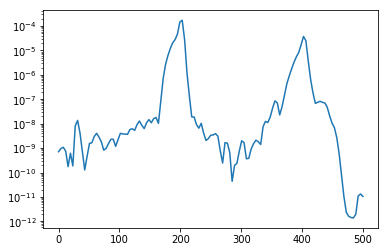

In [120]:
plt.semilogy(f,pxx_den)
plt.show()

In [121]:
indx = np.where((behav['file'] == 'ma2-hN'))[0]
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
f,pxx_den = scipy.signal.welch(myhg[552:994],1000)

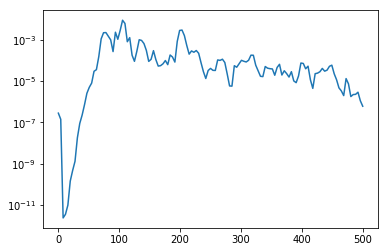

In [122]:
plt.semilogy(f,pxx_den)
plt.show()

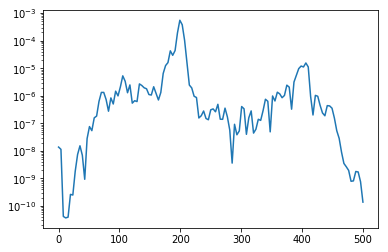

In [123]:
f, Pxy = signal.csd(myhg[552:994], y, 1000)
plt.semilogy(f, np.abs(Pxy))
plt.show()

In [124]:
cxy, fcoh = signal.coherence(myhg[552:994], y)

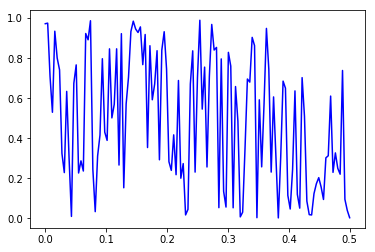

In [125]:
plt.plot(cxy, fcoh, 'b-')
plt.show()


## Try classifier online

In [5]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram

/Users/alia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6



In [102]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz


def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0)
    c = 1
    for label, sub_dir in enumerate(sub_dirs):
        c+=1
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print("Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, c)
            
#             print(labels)
    return np.array(features), np.array(labels)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return (one_hot_encode)

In [57]:
fn = '/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/mi2-hN.wav'
fn.split('/')[9]

'mi2-hN.wav'

In [103]:
import glob
import os
parent_dir = '/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/'
tr_sub_dirs = ["stimwav"]
ts_sub_dirs = ["FFR"]
tr_features, tr_labels = parse_audio_files(parent_dir, tr_sub_dirs)
ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)


/Users/alia/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/alia/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1640: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/alia/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



In [101]:
training_epochs = 50
n_dim = tr_features.shape[1]
n_classes = 80
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [98]:

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

In [99]:
cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [100]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print("Test accuracy: ",round(session.run(accuracy, 
    	feed_dict={X: ts_features,Y: ts_labels}),3))

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
print ("F-Score:", round(f,3))

ValueError: could not convert string to float: 'ma2-hN.wav'